## **SALES FORECASTING MODEL**

The objective of this model is to forecast the sales of individual products across the country. 

| ***The Data Dictionary*** |  |
| --------------------------- |----|
| **Column Name** | **Description** |
| *Target* | the total sales for a product category at a particular store at a given date |
| *Stores_id* | the unique store id |
| *Category_id* | the unique Product category id |
| *Date* | date in numerical representation |
| *Onpromotion* | gives the total number of items in a Product category that were being promoted at a store at a given date |
| *Nbr_of_transactions* | the total number of transactions happened at a store at a given date |
| *year_weekofyear* | the combination of the year and the week of the year, (year_weekofyear = year*100+week_of_year) |
| *ID* | the unique identifier for each row in the testing set: year_week_{year_weekofyear}_{store_id}_{Category_id} |


In [1]:
# Importation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#read the data
df = pd.read_csv('../Data/train.csv')
df.dtypes

date                    object
store_id                object
category_id             object
target                 float64
onpromotion              int64
nbr_of_transactions      int64
dtype: object

In [3]:
#change date column to datetime
df['date'] = pd.to_datetime(df['date'])
df

,date,store_id,category_id,target,onpromotion,nbr_of_transactions
0,1900-12-30,store_1,category_24,0.00000,0,0
1,1900-12-30,store_1,category_21,0.00000,0,0
2,1900-12-30,store_1,category_32,0.00000,0,0
3,1900-12-30,store_1,category_18,0.00000,0,0
4,1900-12-30,store_1,category_26,0.00000,0,0
...,...,...,...,...,...,...
1048570,1902-08-10,store_3,category_23,929.36597,0,2953
1048571,1902-08-10,store_3,category_20,274.99300,0,2953
1048572,1902-08-10,store_3,category_15,6492.75600,0,2953
1048573,1902-08-10,store_3,category_29,1.00000,0,2953


In [43]:
start_date = df.date.min()
end_date = df.date.max()
date_range = pd.date_range(start=start_date, end= end_date, freq='D')
date_range
missing_date = date_range.difference(df.date)
missing_date

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

There is no missing data in this dataset

considering target is our sales per product per date, we can aggregate on date and product to have higher volume to forecast.

In [35]:
df['date'].max() - df['date'].min()

Timedelta('588 days 00:00:00')

In [20]:
agg_data = df.groupby(['date','category_id']).sum().reset_index()
agg_data

,date,category_id,store_id,target,onpromotion,nbr_of_transactions
0,1900-12-30,category_0,store_1store_10store_11store_12store_13store_1...,33.000,0,1327
1,1900-12-30,category_1,store_1store_10store_11store_12store_13store_1...,2.000,0,1327
2,1900-12-30,category_10,store_1store_10store_11store_12store_13store_1...,3.000,0,1327
3,1900-12-30,category_11,store_1store_10store_11store_12store_13store_1...,2.000,0,1327
4,1900-12-30,category_12,store_1store_10store_11store_12store_13store_1...,160.157,0,1327
...,...,...,...,...,...,...
19432,1902-08-10,category_5,store_1store_10store_11store_12store_13store_1...,4.000,0,29069
19433,1902-08-10,category_6,store_1store_10store_11store_12store_13store_1...,18.000,0,29069
19434,1902-08-10,category_7,store_1store_10store_11store_12store_13store_1...,58812.754,109,29069
19435,1902-08-10,category_8,store_1store_10store_11store_12store_13store_1...,1367.000,43,29069


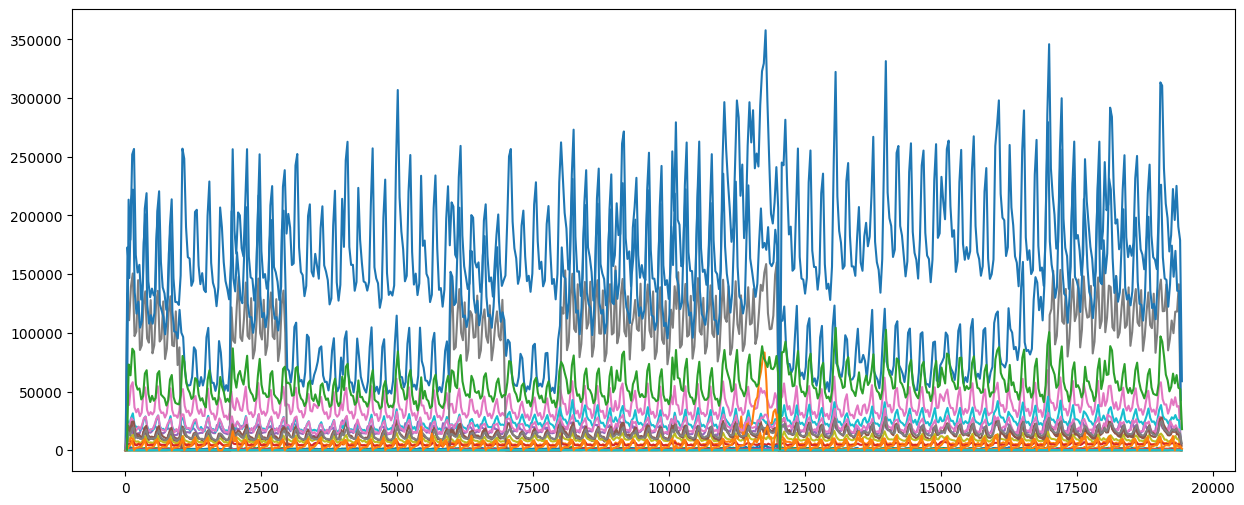

In [39]:
#check trend of all product categories 
for item in agg_data['category_id'].unique():
    data = agg_data[agg_data['category_id'] == item]['target']
    data.plot(figsize=(15,6))
plt.title('Trend of all product categories')
plt.show()

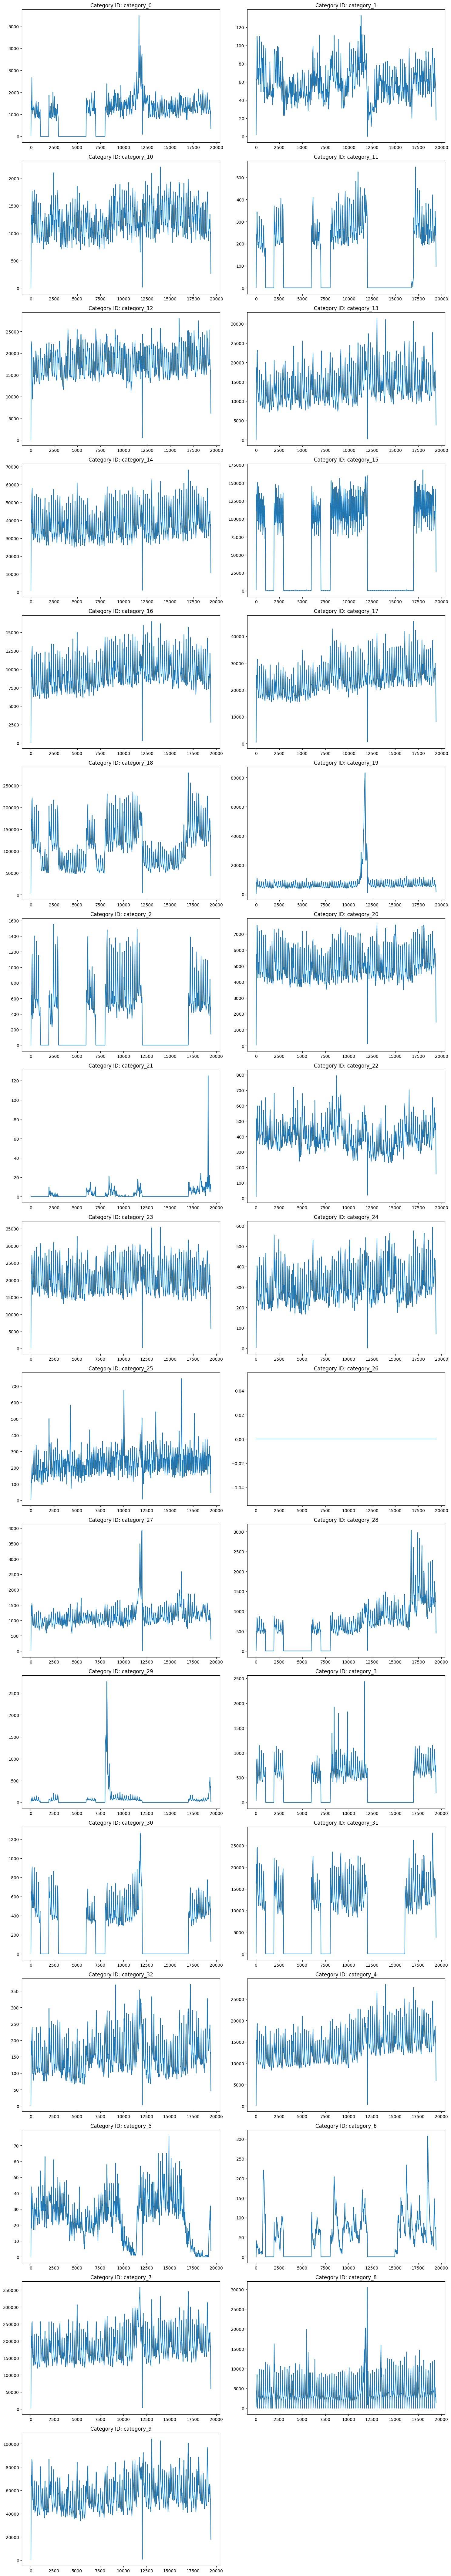

In [37]:
# Number of unique categories
unique_categories = agg_data['category_id'].unique()
num_categories = len(unique_categories)

# Determine the number of rows needed for the subplots
ncols = 2
nrows = (num_categories + ncols - 1) // ncols  # Ceiling division

# Create the subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot each category in its own subplot
for i, item in enumerate(unique_categories):
    data = agg_data[agg_data['category_id'] == item]['target']
    axs[i].plot(data)
    axs[i].set_title(f'Category ID: {item}')

# Hide any empty subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

All product categories have unique trendlines and would need to be forecasted individually to ensure accuracy in the forecast. We will first try out category 9.

In [53]:
agg_data[agg_data['category_id'] == 'category_9'].drop(columns='category_id')

,date,store_id,target,onpromotion,nbr_of_transactions
32,1900-12-30,store_1store_10store_11store_12store_13store_1...,456.0,0,1327
65,1900-12-31,store_1store_10store_11store_12store_13store_1...,73045.0,0,90716
98,1901-01-01,store_1store_10store_11store_12store_13store_1...,63840.0,0,84488
131,1901-01-02,store_1store_10store_11store_12store_13store_1...,86517.0,0,101361
164,1901-01-03,store_1store_10store_11store_12store_13store_1...,84114.0,0,93475
...,...,...,...,...,...
19304,1902-08-06,store_1store_10store_11store_12store_13store_1...,56966.0,85,79233
19337,1902-08-07,store_1store_10store_11store_12store_13store_1...,64049.0,73,87127
19370,1902-08-08,store_1store_10store_11store_12store_13store_1...,53217.0,77,82118
19403,1902-08-09,store_1store_10store_11store_12store_13store_1...,52148.0,82,82224


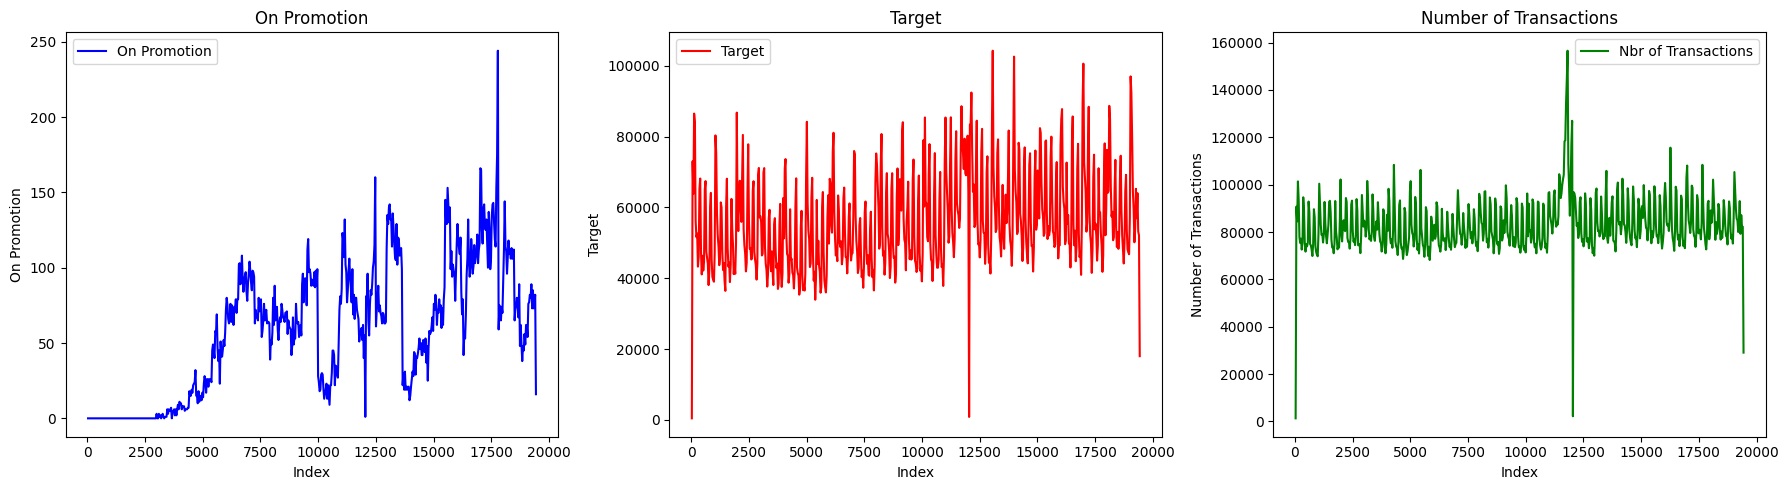

In [60]:
# Filter data for category_9
category_9_data = agg_data[agg_data['category_id'] == 'category_9'].drop(columns='category_id')

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Plot 'onpromotion'
axs[0].plot(category_9_data.index, category_9_data['onpromotion'], label='On Promotion', color='b')
axs[0].set_title('On Promotion')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('On Promotion')
axs[0].legend()

# Plot 'target'
axs[1].plot(category_9_data.index, category_9_data['target'], label='Target', color='r')
axs[1].set_title('Target')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Target')
axs[1].legend()

# Plot 'nbr_of_transactions'
axs[2].plot(category_9_data.index, category_9_data['nbr_of_transactions'], label='Nbr of Transactions', color='g')
axs[2].set_title('Number of Transactions')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Number of Transactions')
axs[2].legend()

plt.tight_layout()
plt.show()